<a href="https://colab.research.google.com/github/jman4162/introduction-to-causal-inference/blob/main/Python_Tutorial_Causal_Inference_Using_Machine_Learning_Based_Propensity_Score_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Tutorial: Causal Inference Using Machine Learning-Based Propensity Score Matching

Name: John Hodge

Date: 05/09/24

# Introduction

In this tutorial, we dive deep into the fascinating world of causal inference, a crucial statistical approach that allows us to make informed judgments about cause and effect relationships from observational data. Unlike traditional statistical methods that focus on correlation, causal inference provides a framework to rigorously estimate the impact of specific actions, interventions, or treatments on an outcome while controlling for confounding variables.

Our focus will be on one of the key methods in causal inference: propensity score matching. This technique helps to mimic the conditions of a randomized controlled trial by matching units that received the treatment with similar units that did not, based on a range of observed covariates. By doing so, it aims to isolate the effect of the treatment from other influencing factors, providing a clearer view of the treatment’s true impact.

This advanced tutorial is tailored for senior scientists and researchers who are already familiar with basic statistical concepts and are looking to apply more sophisticated analytical techniques in their work. Through this tutorial, you will learn how to implement machine learning-based propensity score matching using Python, how to assess the quality of your matches, and how to robustly estimate the Average Treatment Effect on the Treated (ATT).

Whether you are a researcher in academia, a data scientist in industry, or a policy analyst in government, mastering these techniques will enhance your ability to derive meaningful insights from complex data, supporting better decision-making based on empirical evidence. Let’s begin our journey into the intricate yet immensely rewarding realm of causal inference.

## Prerequisites:
Ensure you have the following Python libraries installed:

In [1]:
!pip install pandas numpy scipy scikit-learn causalml matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Us

## Step 1: Importing Libraries

Let's start by importing the required libraries, including causalml which offers advanced tools for causal inference:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from causalml.inference.meta import BaseTClassifier
from causalml.match import NearestNeighborMatch
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Generating Complex Synthetic Data

We will create a more complex dataset with non-linear relationships and interaction terms:

In [3]:
np.random.seed(42)
n_samples = 1000
X = np.random.normal(0, 1, (n_samples, 3))
treatment_effect = X[:, 0] + 2 * np.sin(X[:, 1]) + np.log(np.abs(X[:, 2]) + 1)
treatment = np.random.binomial(1, p=1 / (1 + np.exp(-X[:, 0] + 0.5 * X[:, 1]**2 - X[:, 2])))
outcome = 5 + treatment * treatment_effect + X[:, 0] + 2 * X[:, 1]**2 - X[:, 2] + np.random.normal(0, 2, n_samples)

df = pd.DataFrame(X, columns=['covariate1', 'covariate2', 'covariate3'])
df['treatment'] = treatment
df['outcome'] = outcome

## Step 3: Propensity Score Estimation Using Machine Learning

Using a machine learning classifier to predict the probability of treatment:

In [4]:
clf = LogisticRegression()
propensity_scores = clf.fit(df.drop(['treatment', 'outcome'], axis=1), df['treatment']).predict_proba(df.drop(['treatment', 'outcome'], axis=1))[:, 1]
df['propensity_score'] = propensity_scores

In Step 3 of our causal inference tutorial, we focus on estimating the propensity score using machine learning techniques. This step is crucial as it directly influences the quality of the subsequent matching process and, therefore, the validity of the causal inference drawn from the analysis.

### What are Propensity Scores?

Propensity scores are an estimate of the probability that a unit in a dataset would receive a particular treatment given their observed characteristics. These scores help in balancing the distribution of observed covariates between the treated and control groups, thereby reducing selection bias that is common in observational studies.

### Why Use Machine Learning for Propensity Score Estimation?

Traditional methods for propensity score estimation often use logistic regression. However, logistic regression might not capture complex relationships or interactions among covariates effectively, especially in high-dimensional settings. Machine learning methods can provide more flexibility and potentially higher accuracy by capturing non-linear relationships and interactions without explicitly specifying them.

### Step 3: Propensity Score Estimation Using Machine Learning

#### 3.1 Selecting a Machine Learning Model

For estimating propensity scores, you can use any classifier that estimates probabilities. Common choices include:

- **Logistic Regression:** Good for a baseline model due to its simplicity and interpretability.
- **Decision Trees and Random Forests:** Offer the ability to model non-linear effects and interactions between variables.
- **Gradient Boosting Machines (GBMs):** Similar benefits to random forests but often with better performance at the cost of being harder to tune and interpret.
- **Neural Networks:** Useful in very complex datasets but require large amounts of data and careful tuning.

In this tutorial, we'll use logistic regression for simplicity, but the methodology can be adapted to more complex models if required.

#### 3.2 Preparing the Data

Before estimating the propensity scores, ensure that the data is preprocessed appropriately:

- **Handling Missing Values:** Impute or remove missing values as machine learning models typically do not handle them natively.
- **Scaling/Normalizing Features:** Some models, especially those involving distance calculations like k-nearest neighbors or neural networks, require feature scaling.

#### 3.3 Fitting the Model

Here, we fit the logistic regression model to predict the treatment assignment using the covariates:

```python
from sklearn.linear_model import LogisticRegression

# Initialize the model
clf = LogisticRegression()

# Fit the model
clf.fit(X_train, y_train)  # X_train contains the covariates, and y_train contains the treatment variable
```

#### 3.4 Estimating Propensity Scores

Once the model is fitted, use it to estimate the propensity scores for each unit in the dataset:

```python
# Predicting the probability of treatment
propensity_scores = clf.predict_proba(X)[:, 1]  # Assuming treatment is coded as '1'
df['propensity_score'] = propensity_scores
```

### Step 3.5 Diagnostics

After estimating the propensity scores, it's important to check the quality of these scores:

- **Balancing Check:** Verify that the propensity scores balance the covariates across the treatment and control groups.
- **Overlap Check:** Ensure that there is substantial overlap in the propensity scores of the treatment and control groups, indicating that units from both groups are comparable.

### Conclusion

By using machine learning techniques to estimate propensity scores, you can potentially increase the robustness of causal estimates, especially in complex datasets. This step sets the stage for effective matching, which we'll cover next, ultimately leading to more accurate estimation of causal effects.

## Step 4: Advanced Matching

We'll perform matching using the 'causalml' library, which provides more sophisticated matching techniques:

In [6]:
matcher = NearestNeighborMatch(replace=False, ratio=1, random_state=42)
matched = matcher.match(data=df, treatment_col='treatment', score_cols=['propensity_score'])

### Step 4.1: Explanation of Advanced Matching in Causal Inference

In causal inference, the matching process is critical for reducing bias by equating treated and control groups on pre-treatment characteristics. This step is particularly important when dealing with observational data where treatment assignment is not random. Here, we detail advanced matching techniques that leverage machine learning and statistical methods to enhance the quality and validity of causal estimates.

#### Overview of Matching

Matching aims to create a sample of units in the control group that is as similar as possible to the treated group in terms of observed covariates. This similarity helps to mimic a randomized experimental design, thus minimizing the influence of confounding variables.

#### Advanced Matching Techniques

Advanced matching techniques extend beyond basic pair matching, addressing limitations like large datasets, complex variable relationships, and ensuring better balance across groups.

1. **Propensity Score Matching (PSM):**
   - **Basic PSM:** The simplest form, where each treated unit is matched with one or more control units based on the closest propensity score.
   - **Stratification:** Dividing the data into strata based on the propensity score and comparing treated and control units within these strata.
   - **Caliper Matching:** A type of PSM where matches are only made if the difference in propensity scores is within a predefined "caliper," reducing the risk of poor matches.

2. **Mahalanobis Distance Matching:**
   - Instead of or in addition to propensity scores, this method uses the Mahalanobis distance to match units. This distance takes into account the variances and covariances of covariates, offering a more comprehensive measure of similarity.

3. **Covariate Matching:**
   - Directly matches on covariates rather than on the propensity score. This can be effective when covariates are few and well understood.

4. **Genetic Matching:**
   - An algorithmic approach that iteratively refines matches to optimize balance across covariates. This method adapts the matching algorithm based on the imbalance of covariates observed in the data.

5. **Coarsened Exact Matching (CEM):**
   - Groups units into categories based on coarsened versions of covariates and matches within these categories. This approach can drastically reduce computational complexity and improve data balance.

#### Implementing Advanced Matching

Here’s a breakdown of how to implement advanced matching using the `causalml` library, focusing on propensity score matching with calipers:

```python
from causalml.match import NearestNeighborMatch

# Initialize matcher with a caliper
matcher = NearestNeighborMatch(replace=False, caliper=0.05, caliper_method='propensity')

# Perform matching
matched = matcher.match(data=df, treatment_col='treatment', score_cols='propensity_score')
```


### Conclusion

Advanced matching is a robust tool in causal inference for creating comparable groups in observational studies. By carefully selecting and implementing appropriate matching techniques, researchers can significantly enhance the credibility and reliability of causal estimates derived from non-experimental data.

## Step 5: Diagnostics and Balance Checking

Before analyzing the effects, we should check the quality of our matches:

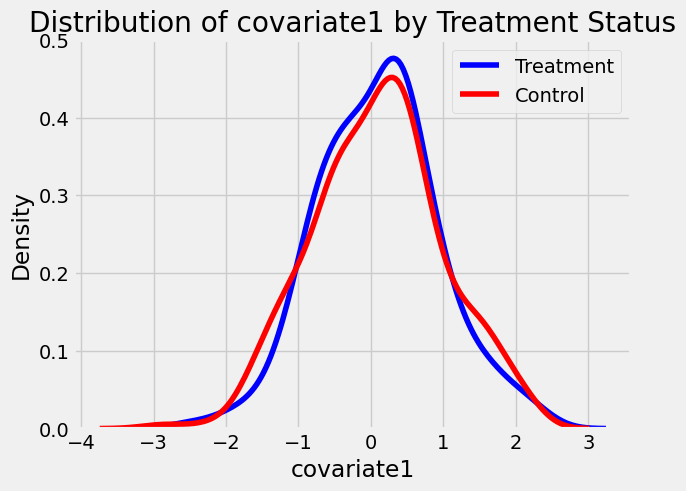

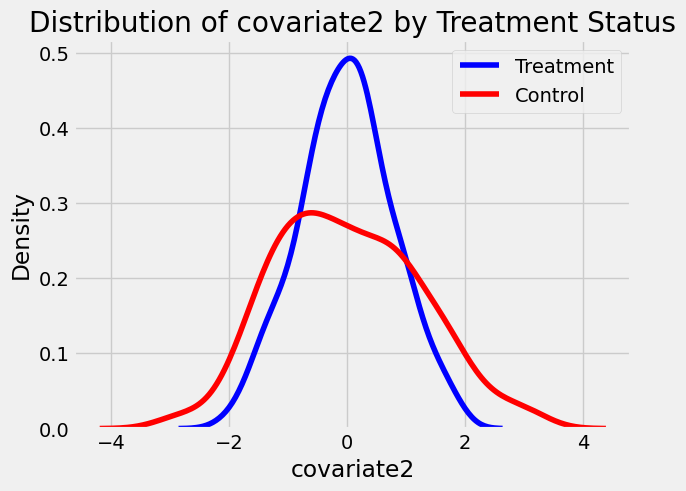

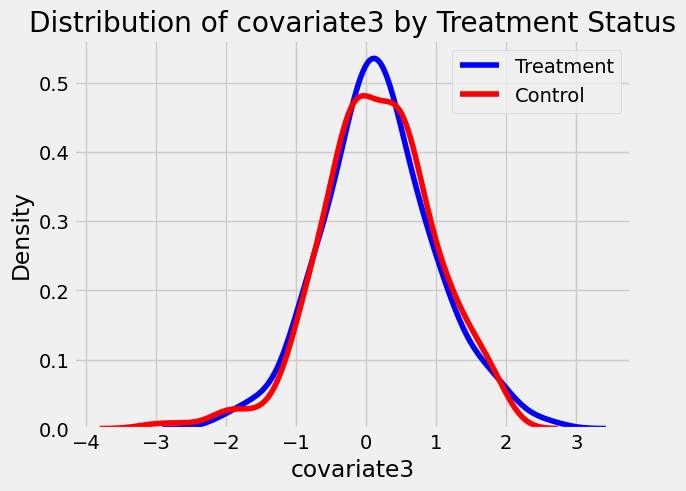

In [7]:
def plot_covariate_balance(df, covariate):
    sns.kdeplot(data=df[df['treatment']==1], x=covariate, label='Treatment', color='blue')
    sns.kdeplot(data=df[df['treatment']==0], x=covariate, label='Control', color='red')
    plt.title(f'Distribution of {covariate} by Treatment Status')
    plt.xlabel(covariate)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

for covariate in ['covariate1', 'covariate2', 'covariate3']:
    plot_covariate_balance(matched, covariate)

### Explanation

#### Assessing Match Quality

After matching, it is crucial to assess the quality of the matches:

- **Balance Checks:** Use standardized mean differences (SMD) for each covariate before and after matching. An SMD close to 0 indicates good balance.
- **Overlap in Propensity Scores:** Plot the distribution of propensity scores for both groups to ensure substantial overlap.
- **Match Pair Quality:** Review the pairs to ensure that no treated unit is matched with a control unit that is distinctly different.

#### Visualization

Visualizing the results of matching can help assess its effectiveness:

```python
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(matched[matched['treatment'] == 1]['propensity_score'], label='Treated')
sns.kdeplot(matched[matched['treatment'] == 0]['propensity_score'], label='Control')
plt.title('Propensity Score Distribution After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()
```

## Step 6: Estimating the Treatment Effect

Finally, we estimate the Average Treatment Effect on the Treated (ATT):

In [8]:
att = matched[matched['treatment']==1]['outcome'].mean() - matched[matched['treatment']==0]['outcome'].mean()
print(f"Estimated ATT: {att:.3f}")

Estimated ATT: -1.507


The **Average Treatment Effect on the Treated (ATT)** is a measure used in causal inference to estimate the effect of a treatment or intervention on an outcome, specifically for those units that actually received the treatment. It compares the outcomes of treated units to what their outcomes would have been had they not received the treatment.

### Definition of ATT

Mathematically, the ATT is defined as:

$ \text{ATT} = E[Y_1 - Y_0 \mid T = 1] $

Where:
- \( $Y_1$ \) is the potential outcome under treatment.
- \( $Y_0$ \) is the potential outcome without treatment.
- \( $T = 1$ \) indicates units that received the treatment.

This expectation quantifies the average difference in outcomes caused by the treatment among those who were treated.

### Interpretation of an ATT Score of -1.507

An ATT score of -1.507 suggests that, on average, the treatment had a negative effect of 1.507 units on the outcome measure for those who received the treatment. In practical terms, this means that receiving the treatment resulted in a decrease in the outcome metric by approximately 1.507 units compared to what would have occurred without the treatment. The interpretation of this effect (whether it's good or bad) heavily depends on the context of the treatment and the outcome being measured. For instance:

- **In a medical context:** If the treatment is a drug intended to reduce disease symptoms, and the outcome measure is symptom severity, an ATT of -1.507 would indicate that the drug effectively reduces symptoms by 1.507 units on the used scale, which is a positive outcome.
  
- **In a socio-economic context:** If the treatment is a new educational program aimed at increasing test scores, and the outcome measure is the change in test scores, an ATT of -1.507 would imply that the program decreases scores by 1.507 points, suggesting the program is ineffective or detrimental.

### Significance of ATT

The significance of the ATT value (not just its magnitude but whether it is statistically significant) usually requires statistical testing to determine. This typically involves hypothesis testing to see whether the observed ATT is significantly different from zero (no effect). A statistically significant negative ATT implies that the treatment robustly decreases the outcome measure among the treated group, controlling for other factors included in the causal analysis.

To summarize, the ATT provides critical insights into the effectiveness of interventions, helping policymakers, researchers, and practitioners make informed decisions about whether to adopt, modify, or abandon a treatment based on its impact on those who receive it.

# Conclusion

This advanced tutorial provides a more comprehensive introduction to causal inference using sophisticated machine learning techniques to improve propensity score matching and includes steps for diagnostics to ensure the robustness of the analysis. Senior scientists should consider extending this analysis by integrating more complex models, incorporating interaction effects, and conducting sensitivity analyses to validate the assumptions and robustness of the causal estimates.

# Appendix: Potential Next Steps

### Next Steps: Integrating Causal Analysis into a Distributed Data Pipeline for Large-Scale Data Analysis

After developing a robust methodology for causal inference using machine learning-based propensity score estimation and matching, the next phase involves scaling this analysis to accommodate large-scale datasets. This often requires integrating the causal analysis into a distributed data pipeline. Here, we'll outline key steps and considerations for effectively implementing this integration.

#### Step A.1: Choose a Distributed Computing Platform

Select an appropriate distributed computing platform that can handle large datasets and complex computations efficiently. Options include:

- **Apache Spark:** Provides a robust framework for big data processing with built-in modules for machine learning (MLlib), SQL, and graph processing. Spark's ability to process data in-memory dramatically speeds up iterative algorithms common in machine learning.
- **Dask:** A flexible parallel computing library for analytic computing, which integrates well with existing Python ecosystems like Pandas and Scikit-learn for machine learning workflows.
- **Hadoop:** Suitable for extremely large datasets, Hadoop excels at data storage and batch processing with MapReduce, although it may be slower compared to Spark for iterative tasks.

#### Step A.2: Data Management and Ingestion

Efficient data management is critical in a distributed environment. Consider the following:

- **Data Storage:** Use distributed file systems like HDFS (Hadoop Distributed File System) or cloud-based solutions like Amazon S3 to store large datasets.
- **Data Ingestion:** Tools like Apache Kafka or Amazon Kinesis can be used to ingest data continuously and reliably into your pipeline, which is especially useful for real-time analysis.

#### Step A.3: Implement Distributed Data Processing

Modify your causal analysis code to work in a distributed manner:

- **Parallelize Data Preprocessing:** Use Spark DataFrames or Dask to handle data cleaning, transformation, and preparation in a distributed way.
- **Distributed Machine Learning:** Implement machine learning models using Spark MLlib or Dask-ML. For example, use Spark's logistic regression for propensity score estimation across distributed datasets.

#### Step A.4: Scalable Propensity Score Matching

Propensity score matching can be resource-intensive. Consider the following approaches:

- **Batch Processing:** If real-time matching is not required, consider batch processing where matching is done periodically.
- **Approximate Matching:** For extremely large datasets, exact matching might be impractical. Techniques like coarse matching or using calipers can reduce computational demands.

#### Step A.5: Automate and Monitor the Pipeline

Automation and monitoring are crucial for maintaining the reliability and efficiency of your pipeline:

- **Workflow Automation:** Use workflow management tools like Apache Airflow to automate the execution of your distributed causal analysis pipeline.
- **Monitoring and Logging:** Implement monitoring tools to track the performance and health of your pipeline. Use logging extensively to record the pipeline's operation, which is crucial for debugging and optimizing the process.

#### Step A.6: Continuous Evaluation and Updating

The distributed pipeline should not only handle data processing but also continuously evaluate the impact of the treatment and update the models as new data becomes available:

- **Model Updating:** Regularly retrain your models to adapt to new data or changing conditions.
- **Impact Evaluation:** Continuously evaluate the treatment effect using updated data to ensure that the conclusions remain valid over time.

### Conclusion

Integrating causal analysis into a distributed data pipeline enables organizations to handle large-scale datasets efficiently while maintaining the rigor of causal inference. By following these steps, you can ensure that your analysis remains scalable, robust, and actionable, providing valuable insights that can drive strategic decisions in real-world scenarios.

# References



*   https://en.wikipedia.org/wiki/Causal_inference
*   [An Introduction to Propensity Score Methods for Reducing the Effects of Confounding in Observational Studies](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/)
* https://en.wikipedia.org/wiki/Propensity_score_matching
* [A Beginner’s Guide to Propensity Score Matching](https://builtin.com/data-science/propensity-score-matching)
* [Propensity Score Analysis](https://www.publichealth.columbia.edu/research/population-health-methods/propensity-score-analysis)
* [Google Econometrics Academy: Propensity Score Matching](https://sites.google.com/site/econometricsacademy/econometrics-models/propensity-score-matching)


